In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [2]:
!pip install fastai==2.4

     |████████████████████████████████| 187 kB 4.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.9 kB/s 
     |████████████████████████████████| 55 kB 5.4 MB/s 
     |████████████████████████████████| 21.0 MB 299 kB/s 
     |████████████████████████████████| 23.2 MB 174 kB/s 
     |████████████████████████████████| 23.3 MB 611 kB/s 
     |████████████████████████████████| 23.3 MB 1.1 MB/s 
     |████████████████████████████████| 22.1 MB 19.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's depende

In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
!mkdir testSet_coco

In [5]:
print(coco_path)

/root/.fastai/data/coco_sample/train_sample


In [6]:
#copy coco to working dir
%cp -r /root/.fastai/data/coco_sample/train_sample/* ./testSet_coco

In [7]:
#select which data dir
datadir = 'testSet_coco'

In [8]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir(f'{datadir}')):
  if i < 1000: # first 1000 will be val
    os.rename(f'{datadir}/' + file, 'images/val/class/' + file)
  else: # others will be train
    os.rename(f'{datadir}/' + file, 'images/train/class/' + file)

In [9]:
#check if files in right place
!ls images/val/class/

000000001144.jpg  000000156120.jpg  000000304336.jpg  000000439758.jpg
000000001522.jpg  000000156806.jpg  000000304391.jpg  000000440177.jpg
000000002347.jpg  000000157378.jpg  000000304760.jpg  000000440444.jpg
000000004970.jpg  000000159763.jpg  000000304941.jpg  000000441460.jpg
000000007288.jpg  000000160014.jpg  000000305788.jpg  000000441523.jpg
000000008042.jpg  000000160181.jpg  000000305876.jpg  000000443259.jpg
000000008043.jpg  000000161287.jpg  000000306080.jpg  000000444233.jpg
000000009186.jpg  000000161599.jpg  000000306212.jpg  000000444682.jpg
000000012307.jpg  000000162041.jpg  000000306407.jpg  000000446494.jpg
000000015259.jpg  000000163348.jpg  000000306456.jpg  000000447087.jpg
000000016342.jpg  000000163518.jpg  000000307238.jpg  000000450270.jpg
000000016725.jpg  000000163829.jpg  000000307266.jpg  000000450383.jpg
000000016732.jpg  000000163917.jpg  000000307322.jpg  000000450544.jpg
000000017236.jpg  000000164102.jpg  000000307573.jpg  000000451594.jpg
000000

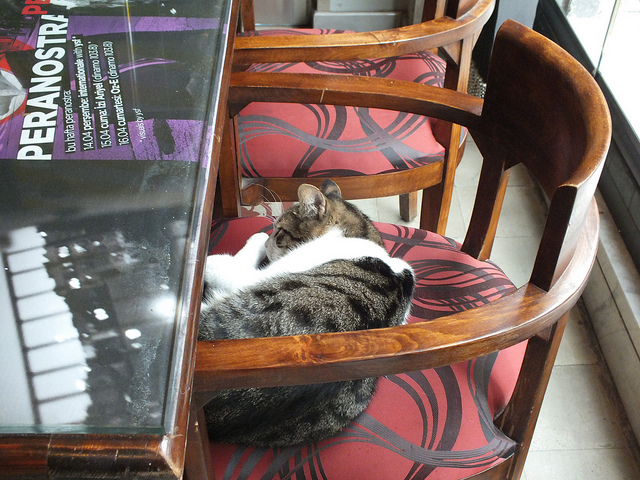

(640, 480)


In [10]:
# Make sure the images are there
from IPython.display import Image, display
from os import listdir
from os.path import isfile, join
import random
import tensorflow as tf

# import required module
from PIL import Image as PILIm
  

onlyfiles = listdir('images/val/class')
imname = random.choice(onlyfiles)
display(Image(filename=f'images/val/class/{imname}'))
print(PILIm.open(f'images/val/class/{imname}').size)

In [11]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

     |████████████████████████████████| 11.3 MB 4.3 MB/s 
     |████████████████████████████████| 112 kB 28.2 MB/s 
  Using cached torchvision-0.12.0-cp37-cp37m-manylinux1_x86_64.whl (21.0 MB)
  Using cached torchvision-0.11.3-cp37-cp37m-manylinux1_x86_64.whl (23.2 MB)
  Using cached torchvision-0.11.2-cp37-cp37m-manylinux1_x86_64.whl (23.3 MB)
  Using cached torchvision-0.11.1-cp37-cp37m-manylinux1_x86_64.whl (23.3 MB)
     |████████████████████████████████| 22.1 MB 345 kB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
     |████████████████████████████████| 17.4 MB 557 kB/s 
     |████████████████████████████████| 804.1 MB 2.8 kB/s 
     |████████████████████████████████| 13.5 MB 76.1 MB/s 
     |████████████████████████████████| 13.3 MB 55.7 MB/s 
     |████████████████████████████████| 55.4 MB 99.3 MB/s 
     |████████████████████████████████| 29.2 MB 4.1 MB/s 
     |████████████████████████████████| 29.2 MB 1.2 MB/s 
     |████████████████████████████████| 29.2 MB 4

In [12]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [13]:
use_gpu = torch.cuda.is_available()

In [14]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [15]:
criterion = nn.MSELoss()

In [16]:
model = ColorizationNet()

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.02)

In [18]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [32]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train/', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val/' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [20]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [21]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [22]:
torch.no_grad()

In [33]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [34]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [35]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 10

In [36]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/326]	Time 2.897 (2.897)	Data 1.495 (1.495)	Loss 0.0054 (0.0054)	
Epoch: [0][25/326]	Time 1.629 (1.620)	Data 1.560 (1.499)	Loss 0.0046 (0.0055)	
Epoch: [0][50/326]	Time 1.570 (1.605)	Data 1.502 (1.510)	Loss 0.0056 (0.0055)	
Epoch: [0][75/326]	Time 1.539 (1.595)	Data 1.471 (1.508)	Loss 0.0046 (0.0054)	
Epoch: [0][100/326]	Time 1.563 (1.588)	Data 1.491 (1.506)	Loss 0.0056 (0.0053)	
Epoch: [0][125/326]	Time 1.573 (1.585)	Data 1.504 (1.505)	Loss 0.0047 (0.0053)	
Epoch: [0][150/326]	Time 1.535 (1.584)	Data 1.466 (1.506)	Loss 0.0042 (0.0052)	
Epoch: [0][175/326]	Time 1.564 (1.584)	Data 1.495 (1.507)	Loss 0.0049 (0.0052)	
Epoch: [0][200/326]	Time 1.571 (1.584)	Data 1.502 (1.508)	Loss 0.0042 (0.0051)	
Epoch: [0][225/326]	Time 1.522 (1.582)	Data 1.453 (1.507)	Loss 0.0045 (0.0051)	
Epoch: [0][250/326]	Time 1.632 (1.582)	Data 1.563 (1.507)	Loss 0.0042 (0.0051)	
Epoch: [0][275/326]	Time 1.570 (1.581)	Data 1.502 (1.507)	Loss 0.0049 (0.0050)	
Epoch: [0][300/326]

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 55 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/16]	Time 1.951 (1.951)	Loss 0.0044 (0.0044)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/326]	Time 1.653 (1.653)	Data 1.584 (1.584)	Loss 0.0039 (0.0039)	
Epoch: [1][25/326]	Time 1.588 (1.591)	Data 1.519 (1.522)	Loss 0.0035 (0.0044)	
Epoch: [1][50/326]	Time 1.540 (1.579)	Data 1.472 (1.510)	Loss 0.0043 (0.0044)	
Epoch: [1][75/326]	Time 1.631 (1.577)	Data 1.561 (1.508)	Loss 0.0047 (0.0044)	
Epoch: [1][100/326]	Time 1.574 (1.575)	Data 1.505 (1.506)	Loss 0.0035 (0.0043)	
Epoch: [1][125/326]	Time 1.557 (1.575)	Data 1.488 (1.506)	Loss 0.0040 (0.0043)	
Epoch: [1][150/326]	Time 1.580 (1.575)	Data 1.511 (1.506)	Loss 0.0042 (0.0043)	
Epoch: [1][175/326]	Time 1.592 (1.573)	Data 1.523 (1.505)	Loss 0.0041 (0.0043)	
Epoch: [1][200/326]	Time 1.544 (1.573)	Data 1.475 (1.504)	Loss 0.0037 (0.0043)	
Epoch: [1][225/326]	Time 1.610 (1.573)	Data 1.541 (1.504)	Loss 0.0036 (0.0042)	
Epoch: [1][250/326]	Time 1.519 (1.573)	Data 1.450 (1.504)	Loss 0.0040 (0.0042)	
Epoch: [1][275/326]	

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 22 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/16]	Time 1.921 (1.921)	Loss 0.0037 (0.0037)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/326]	Time 1.579 (1.579)	Data 1.494 (1.494)	Loss 0.0037 (0.0037)	
Epoch: [2][25/326]	Time 1.529 (1.583)	Data 1.461 (1.513)	Loss 0.0036 (0.0038)	
Epoch: [2][50/326]	Time 1.544 (1.580)	Data 1.476 (1.510)	Loss 0.0034 (0.0038)	
Epoch: [2][75/326]	Time 1.595 (1.573)	Data 1.526 (1.504)	Loss 0.0040 (0.0038)	
Epoch: [2][100/326]	Time 1.531 (1.574)	Data 1.463 (1.505)	Loss 0.0030 (0.0038)	
Epoch: [2][125/326]	Time 1.525 (1.575)	Data 1.456 (1.505)	Loss 0.0030 (0.0038)	
Epoch: [2][150/326]	Time 1.530 (1.573)	Data 1.461 (1.504)	Loss 0.0033 (0.0038)	
Epoch: [2][175/326]	Time 1.557 (1.573)	Data 1.487 (1.504)	Loss 0.0036 (0.0038)	
Epoch: [2][200/326]	Time 1.541 (1.573)	Data 1.472 (1.504)	Loss 0.0036 (0.0038)	
Epoch: [2][225/326]	Time 1.590 (1.574)	Data 1.522 (1.505)	Loss 0.0035 (0.0038)	
Epoch: [2][250/326]	Time 1.613 (1.574)	Data 1.544 (1.505)	Loss 0.0040 (0.0037)	
Epoch: [2][275/326]	

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/16]	Time 1.975 (1.975)	Loss 0.0035 (0.0035)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/326]	Time 1.547 (1.547)	Data 1.463 (1.463)	Loss 0.0031 (0.0031)	
Epoch: [3][25/326]	Time 1.542 (1.568)	Data 1.473 (1.498)	Loss 0.0041 (0.0035)	
Epoch: [3][50/326]	Time 1.561 (1.571)	Data 1.492 (1.502)	Loss 0.0038 (0.0035)	
Epoch: [3][75/326]	Time 1.574 (1.573)	Data 1.504 (1.503)	Loss 0.0042 (0.0035)	
Epoch: [3][100/326]	Time 1.592 (1.577)	Data 1.523 (1.508)	Loss 0.0041 (0.0035)	
Epoch: [3][125/326]	Time 1.559 (1.577)	Data 1.489 (1.508)	Loss 0.0039 (0.0036)	
Epoch: [3][150/326]	Time 1.593 (1.577)	Data 1.524 (1.508)	Loss 0.0030 (0.0035)	
Epoch: [3][175/326]	Time 1.555 (1.578)	Data 1.486 (1.509)	Loss 0.0031 (0.0035)	
Epoch: [3][200/326]	Time 1.622 (1.581)	Data 1.554 (1.512)	Loss 0.0028 (0.0035)	
Epoch: [3][225/326]	Time 1.583 (1.579)	Data 1.514 (1.510)	Loss 0.0039 (0.0035)	
Epoch: [3][250/326]	Time 1.595 (1.579)	Data 1.526 (1.510)	Loss 0.0036 (0.0035)	
Epoch: [3][275/326]	

<Figure size 432x288 with 0 Axes>

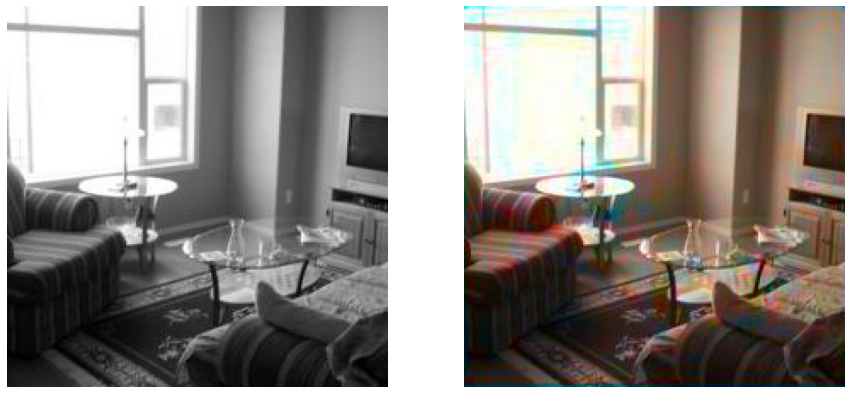

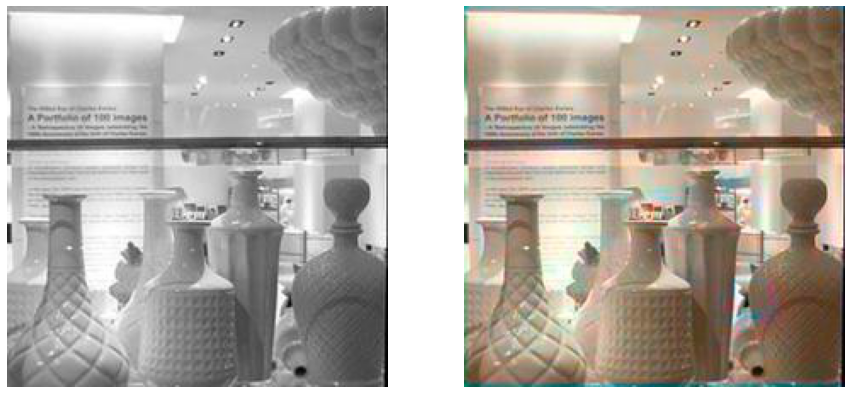

In [37]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-2-epoch-0.jpg', 'outputs/gray/img-2-epoch-0.jpg'),
               ('outputs/color/img-7-epoch-0.jpg', 'outputs/gray/img-7-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()